# Deep Learning for Medical Imaging Demonstration

In [48]:
# usual imports for pytorch project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from pathlib import Path

## Data and Preprocessing

First, we have to get the data which is found at https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia?resource=download 

We have put it in the folder data/chest_xray

In [2]:
DATA_DIR = 'data/chest_xray/'

In [3]:
from torchvision.datasets import ImageFolder

train_ds = ImageFolder(DATA_DIR + 'train')
test_ds = ImageFolder(DATA_DIR + 'test')

Let's look at some data statistics. 

In [4]:
print("Classes", train_ds.classes)
print("Train size", len(train_ds))
print("Test size", len(test_ds))

num_examples_by_class = [0] * len(train_ds.classes)

train_ds.num_examples_by_class = {}
test_ds.num_examples_by_class = {}

for class_ in train_ds.classes:
    num_examples = len(os.listdir(DATA_DIR + 'train/' + class_))
    print(f'train/{class_}: {num_examples}')
    train_ds.num_examples_by_class[class_] = num_examples
    num_examples = len(os.listdir(DATA_DIR + 'test/' + class_))
    print(f'test/{class_}: {num_examples}')

Classes ['COVID19', 'NORMAL', 'PNEUMONIA']
Train size 5144
Test size 1288
train/COVID19: 460
test/COVID19: 116
train/NORMAL: 1266
test/NORMAL: 317
train/PNEUMONIA: 3418
test/PNEUMONIA: 855


Notice that there is some serious class imbalance (way more pneumonia than covid), which is something we need to keep in mind.

A training example is an image and label from the classes:

COVID19


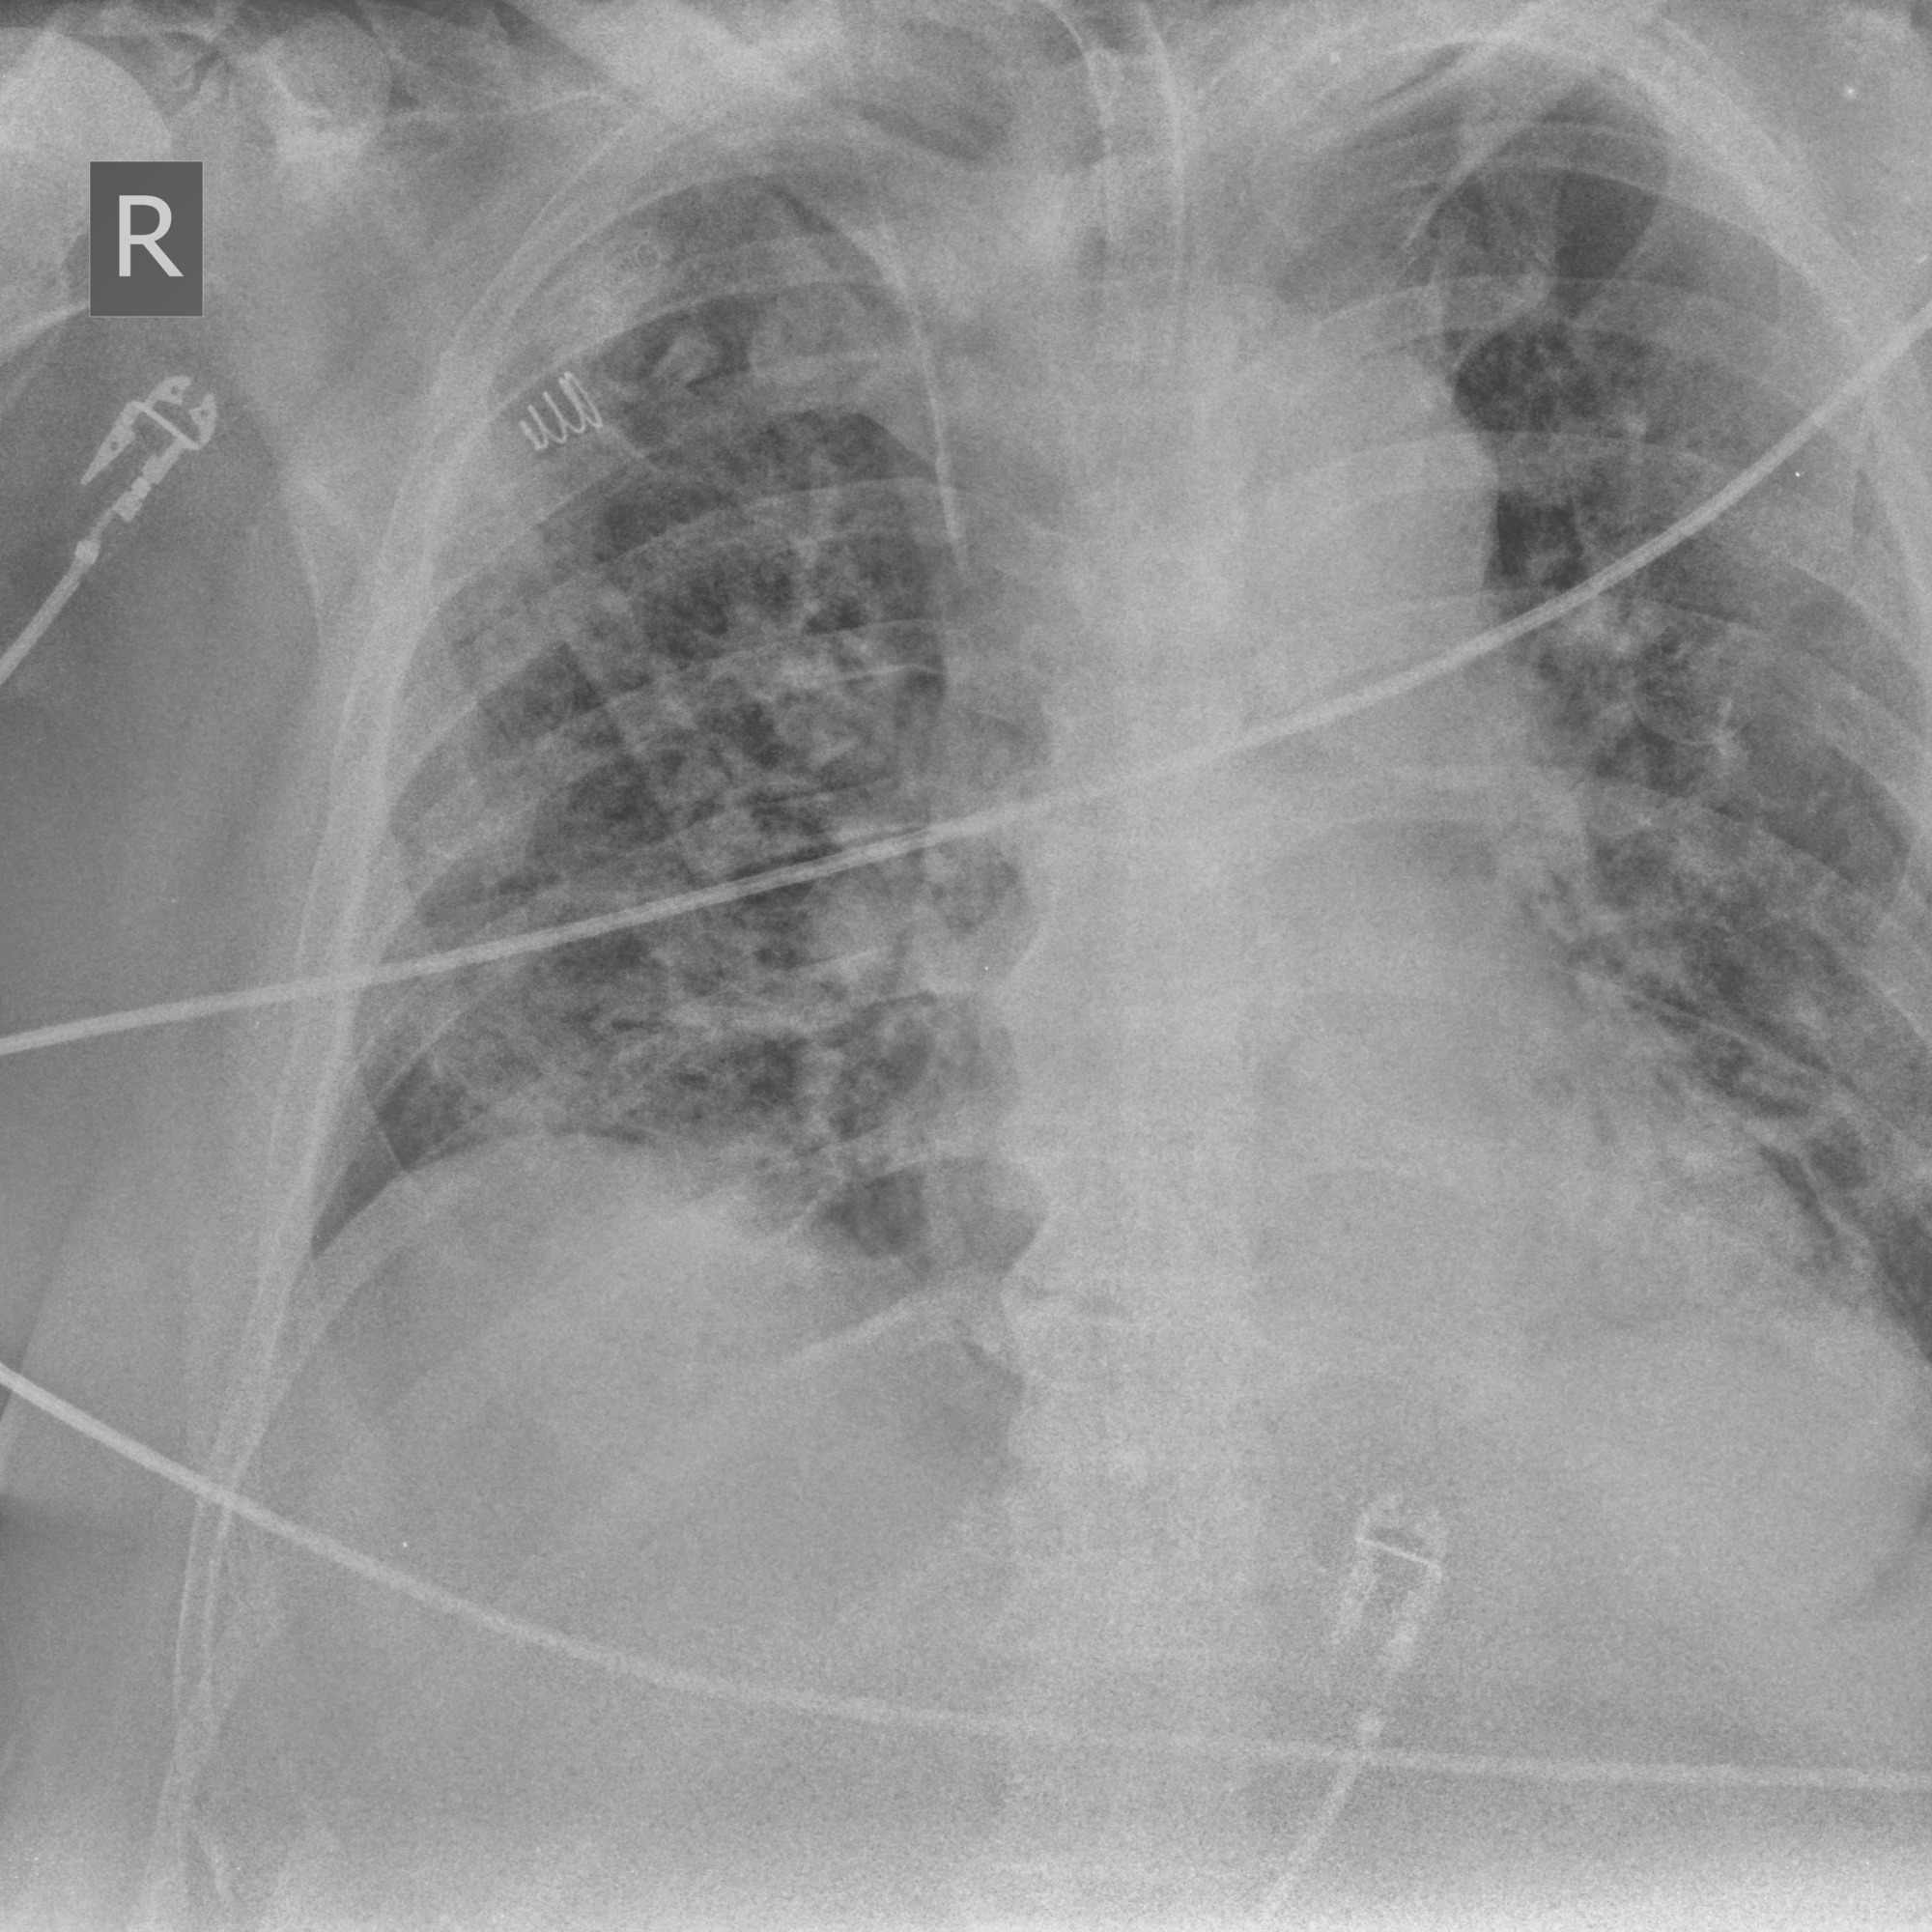

In [5]:
image, label = train_ds[0]
print(train_ds.classes[label])
image

Right now, the image is a PIL image. We need to get it into a tensor.

In [6]:
from torchvision.transforms import ToTensor
train_ds.transform = ToTensor()

image, label = train_ds[0]
image

tensor([[[0.3255, 0.3294, 0.3373,  ..., 0.5216, 0.5098, 0.5255],
         [0.3451, 0.3333, 0.3255,  ..., 0.5137, 0.5098, 0.5216],
         [0.3373, 0.3373, 0.3333,  ..., 0.4941, 0.4902, 0.4980],
         ...,
         [0.8000, 0.7882, 0.7922,  ..., 0.8745, 0.8863, 0.8706],
         [0.8196, 0.8000, 0.7961,  ..., 0.8667, 0.8784, 0.8706],
         [0.8039, 0.7882, 0.8000,  ..., 0.8627, 0.8706, 0.8706]],

        [[0.3255, 0.3294, 0.3373,  ..., 0.5216, 0.5098, 0.5255],
         [0.3451, 0.3333, 0.3255,  ..., 0.5137, 0.5098, 0.5216],
         [0.3373, 0.3373, 0.3333,  ..., 0.4941, 0.4902, 0.4980],
         ...,
         [0.8000, 0.7882, 0.7922,  ..., 0.8745, 0.8863, 0.8706],
         [0.8196, 0.8000, 0.7961,  ..., 0.8667, 0.8784, 0.8706],
         [0.8039, 0.7882, 0.8000,  ..., 0.8627, 0.8706, 0.8706]],

        [[0.3255, 0.3294, 0.3373,  ..., 0.5216, 0.5098, 0.5255],
         [0.3451, 0.3333, 0.3255,  ..., 0.5137, 0.5098, 0.5216],
         [0.3373, 0.3373, 0.3333,  ..., 0.4941, 0.4902, 0.

Notice the pixel values are from 0 to 1:

(array([  52290.,  399120.,  978711., 1511877., 2274954., 3815823.,
        2436237.,  396105.,  109776.,   25107.]),
 array([0.23529412, 0.3047059 , 0.37411764, 0.44352943, 0.5129412 ,
        0.58235294, 0.6517647 , 0.72117645, 0.79058826, 0.86      ,
        0.92941177], dtype=float32),
 <BarContainer object of 10 artists>)

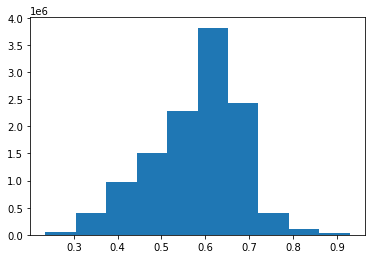

In [7]:
import numpy as np
pixel_array = np.array(train_ds[0][0])
plt.hist(pixel_array.flatten())

We want to normalize them, so we should compute the mean and standard deviation of pixel values across the dataset. 

__COMPUTE THE NORM BASED ON THE TRAIN SET, NOT THE TEST SET!__

In [8]:
# compute mean and std
from tqdm.notebook import tqdm # progress bar

def compute_mean_and_std(ds):
    for i in tqdm(range(len(train_ds))):
        image, label = train_ds[i]
        pixel_array = np.array(image)
        if i == 0:
            mean = pixel_array.mean(axis=(1, 2))
            std = pixel_array.std(axis=(1, 2))
        else:
            mean += pixel_array.mean(axis=(1, 2))
            std += pixel_array.std(axis=(1, 2))

    mean /= len(train_ds)
    std /= len(train_ds)

    return mean, std

# THIS TAKES A WHILE! USE THE VALUES BELOW
# mean, std = compute_mean_and_std(train_ds)

MEAN = [0.49236146, 0.49245372, 0.49254265]
STD = [0.21767499, 0.21769916, 0.21771288]

Now we can use these values to normalize our data. We also resize and center crop the images:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'COVID19')

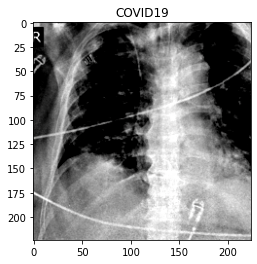

In [9]:
from torchvision import transforms as T 
transform = T.Compose([
    T.Resize((256, 256)), 
    T.CenterCrop((224, 224)),
    T.ToTensor(),
    T.Normalize(MEAN, STD)
])

train_ds.transform = transform
test_ds.transform = transform

image, label = train_ds[0]

plt.imshow(image.permute(1, 2, 0))
plt.title(train_ds.classes[label])

## Training a baseline model

To train a model with pytorch, we need a few things: 
- a model `torch.nn.Module` class
- an optimizer 
- a dataloader 

Let's try first with a very simple convolutional network:

In [10]:
# simple convnet    
from torch import nn
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class ConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(56*56*64, 1000)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.pool2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        return out

model = ConvNet(num_classes=3).to(DEVICE)

Let's test a forward pass on a data item:

In [11]:
# sample pass 
image, label = train_ds[0]
image = image.unsqueeze(0).to(DEVICE)
model(image)

tensor([[0.0812, 0.0228, 0.0121]], device='cuda:0', grad_fn=<AddmmBackward0>)

These are the raw class scores which we will optimize.

Now let's get the dataloaders ready. We will use a batch size of 32. We also split the train set into train and validation sets.

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
len_train = int(0.8 * len(train_ds))
len_val = len(train_ds) - len_train
train_ds, val_ds = torch.utils.data.random_split(train_ds, [len_train, len_val])

In [13]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

Dataloaders iterate through batches which are stacks of images and labels: 

In [14]:
# sample batch
for images, labels in train_dl:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


Now we need to create an optimizer. Let's use Adam which is the go-to:

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [24]:
# training loop
from os.path import join
ckpt_dir = join('demo_checkpoints', 'v1')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

def train(model, train_dl, val_dl, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        for images, labels in tqdm(train_dl, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        train_loss /= len(train_dl)
        train_acc = correct / len(train_dl.dataset)
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in tqdm(val_dl, desc=f'Epoch {epoch+1}/{num_epochs}'):
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        val_loss /= len(val_dl)
        val_losses.append(val_loss)
        val_acc = correct / len(val_dl.dataset)
        val_accs.append(val_acc)
        
        torch.save(model.state_dict(), f'demo_checkpoints/v1/model_{epoch+1}.pt')
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    results = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_accs, 'val_acc': val_accs})
    results.to_csv(join('demo_checkpoints', 'v1', 'results.csv'), index=False)

# train(model, train_dl, val_dl, criterion, optimizer, num_epochs=5)

<All keys matched successfully>

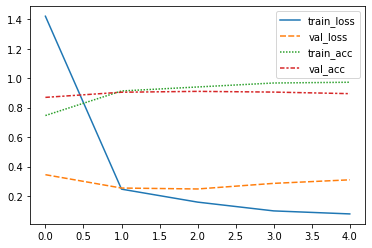

In [25]:
results = pd.read_csv(join('demo_checkpoints', 'v1', 'results.csv'))
import seaborn as sns
sns.lineplot(data=results)

best_epoch = results.val_loss.idxmin() + 1
model.load_state_dict(torch.load(join('demo_checkpoints', 'v1', f'model_{best_epoch}.pt')))

Looks like the model overfitted but still performed well. Let's look at the predictions on the test set:

In [26]:
CLASSES = test_ds.classes

def test(model, test_dl):
    model.eval()
    outputs_collection = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_dl, desc='Testing'):
            images = images.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(len(images)):
                pred = preds[i].item()
                label = labels[i].item()
                output = outputs[i].tolist()

                pred = CLASSES[pred]
                label = CLASSES[label]

                outputs_collection.append({
                    'pred': pred, 
                    'label': label,
                    'output': output,
                })
        
    return pd.DataFrame(outputs_collection)

test_df = test(model, test_dl)

Testing:   0%|          | 0/41 [00:00<?, ?it/s]

In [28]:
test_df['correct'] = test_df.pred == test_df.label

In [30]:
test_df.groupby('label').correct.mean()

label
COVID19      0.862069
NORMAL       0.845426
PNEUMONIA    0.955556
Name: correct, dtype: float64

Looks like the model was most accurate for detecting pneumonia - this makes sense because, as we remember, there are far more pneumonia examples than the other examples.

## Adding data augmentations

Our model worked well but the training performance went up faster than validation. Let's use data augmentations to see if we can improve the performance.

In [46]:
augmentation = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomResizedCrop(224, scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333)), 
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize(MEAN, STD), 
])

train_ds.dataset.transform = augmentation

Let's visualize some of the different views this produces:

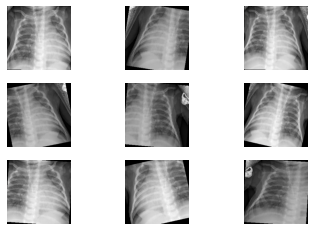

In [47]:
fig, ax = plt.subplots(3, 3, )
for ax in ax.flatten():
    # sample image
    img, label = train_ds[0]

    # convert to numpy and unnormalize
    img = (img - img.min()) / (img.max() - img.min())
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')

As we see the same image, image 0 in the dataset, now looks different every time. The model will be less capable of memorization. 

Define the training loop: 


In [52]:
def train(model, train_dl, val_dl, optimizer, criterion, exp_dir, num_epochs=5):
    if not Path(exp_dir).exists(): 
        Path(exp_dir).mkdir(parents=True)

    results = []

    for epoch in range(1, num_epochs+1):
        epoch_results = {'epoch': epoch}

        # collect predictions and labels to compute accuracy later
        train_logits = [] 
        train_labels = [] 

        for batch in tqdm(train_dl, desc=f'Epoch {epoch}/{num_epochs}', leave=True):
            images, labels = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_logits.append(outputs)
            train_labels.append(labels)

        # compute training accuracy
        train_logits = torch.cat(train_logits, dim=0)
        train_labels = torch.cat(train_labels, dim=0)
        train_acc = (train_logits.argmax(1) == train_labels).type(torch.float).mean().item()
        epoch_results['train_acc'] = train_acc

        # collect predictions and labels to compute accuracy later
        val_logits = []
        val_labels = []

        for batch in tqdm(val_dl, desc=f'Epoch {epoch}/{num_epochs}', leave=True):
            images, labels = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.no_grad():
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_logits.append(outputs)
            val_labels.append(labels)

        # compute validation accuracy
        val_logits = torch.cat(val_logits, dim=0)
        val_labels = torch.cat(val_labels, dim=0)

        val_acc = (val_logits.argmax(1) == val_labels).type(torch.float).mean().item()
        epoch_results['val_acc'] = val_acc
    
        results.append(epoch_results)

        # save model weights
        torch.save(model.state_dict(), join(exp_dir, f'model_{epoch}.pt'))

    results = pd.DataFrame(results)
    results.to_csv(join(exp_dir, 'train_results.csv'), index=False)

    # find best epoch
    best_epoch = results.val_acc.idxmax() + 1
    # load best epoch weights
    model.load_state_dict(torch.load(join(exp_dir, f'model_{best_epoch}.pt')))

    # test the model 
    test_results = test(model, test_dl)
    test_results.to_csv(join(exp_dir, 'test_results.csv'), index=False)


This time we'll use a bigger model, which we can load from torchvision. We'll also use pretrained imagenet weights which can help.

In [53]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)
# need to change the last layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, len(CLASSES))
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

exp_dir = join('demo_checkpoints', 'v2')
train(model, train_dl, val_dl, optimizer, criterion, exp_dir, num_epochs=5)

/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5:   0%|          | 0/129 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/129 [00:00<?, ?it/s]